# Models

Matt Thomas, Max McGaw, Liam Mulcahy, Will Carruthers

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import pandas as pd

In [2]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#We can use the sample.csv to speed things up while tuning models
#df = spark.read.csv('train_data.csv', inferSchema=True, header=True)
df = spark.read.csv('sample.csv', inferSchema=True, header=True)

In [5]:
df.show(2)

+------+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+
|   _c0|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|grade_CD|grade_EFG|emp_length_low|
+------+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+
|625057|                 0|  35000.0| 36 months|    7.99|      MORTGAGE|   456527.0|   38768.76|  250000.0|        MI|         775.0|        2165.42|       0|        0|             0|
|394994|                 0|   8000.0| 36 months|   11.49|          RENT|    35497.0|   8643.126|   50000.0|        CA|         670.0|         6543.1|       0|        0|             0|
+------+------------------+---------+----------+--------+--------------+--------

In [6]:
dfs = df.select([col for col in df.columns if col not in ['_c0']])

In [7]:
dfs.show(5)

+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+
|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|grade_CD|grade_EFG|emp_length_low|
+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+
|                 0|  35000.0| 36 months|    7.99|      MORTGAGE|   456527.0|   38768.76|  250000.0|        MI|         775.0|        2165.42|       0|        0|             0|
|                 0|   8000.0| 36 months|   11.49|          RENT|    35497.0|   8643.126|   50000.0|        CA|         670.0|         6543.1|       0|        0|             0|
|                 0|  35000.0| 36 months|   10.08|      MORTGAGE|   424094.0|    8340.06|  126000.0|        NJ|    

In [8]:
dfs.printSchema()

root
 |-- loan_status_binary: integer (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- tot_cur_bal: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- fico_range_low: double (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- grade_CD: integer (nullable = true)
 |-- grade_EFG: integer (nullable = true)
 |-- emp_length_low: integer (nullable = true)



In [9]:
dfs.filter(dfs['tot_cur_bal'].isNull()).count()
#Need to do something abou this

20922

In [10]:
train, test = dfs.randomSplit([0.8, 0.2], seed=12345)

In [11]:
categories = ['home_ownership', 'term']
stages = []

In [12]:
for col in categories:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + "_Index")
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(),
                            outputCol=col + "classVec")
    stages += [stringIndexer, encoder]

In [13]:
scaled_vectors = VectorAssembler(inputCols = ['loan_amnt',\
                                             'total_pymnt', 'annual_inc', \
                                             'fico_range_low', 'last_pymnt_amnt',\
                                             'int_rate','emp_length_low'], 
                                 outputCol='vector_features')

In [14]:
scaler = StandardScaler(inputCol='vector_features', outputCol='scaled_features')

In [15]:
labelIndexer = StringIndexer(inputCol='loan_status_binary', outputCol='label')

In [16]:
#AT added
assembler = VectorAssembler(inputCols=['scaled_features', 'home_ownershipclassVec', 'termclassVec', 'grade_EFG', 'grade_CD' ], outputCol='features')

In [17]:
stages += [scaled_vectors, scaler, labelIndexer, assembler]

In [18]:
lr = LogisticRegression(maxIter=10, regParam=0.1)
stages += [lr]
stages

[StringIndexer_2b2a8f720b39,
 OneHotEncoder_82756b3c5e55,
 StringIndexer_ec96c8670078,
 OneHotEncoder_cc507b2acaee,
 VectorAssembler_fab784ec511c,
 StandardScaler_3fbcaf6f0b26,
 StringIndexer_eb984e13538e,
 VectorAssembler_43a8d2e1db1b,
 LogisticRegression_7156ec125f17]

In [19]:
pipeline = Pipeline(stages=stages)

In [20]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, .001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.2, 0.8, 1.0])\
    .build()

In [21]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

In [22]:
# Fit the pipeline
model = crossval.fit(train)

In [47]:
# Make a prediction
prediction = model.transform(test)
prediction.show(2)

+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+--------------------+----------------------+----------+-------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|grade_CD|grade_EFG|emp_length_low|home_ownership_Index|home_ownershipclassVec|term_Index| termclassVec|     vector_features|     scaled_features|label|            features|       rawPrediction|         probability|prediction|
+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+--------------------+----------------------+----------+-------------+-------------------

In [24]:
prediction = prediction.withColumn("loan_status_binary", df["loan_status_binary"].cast('float'))
#This is necessary to compare predictions with actual values

In [25]:
matches = prediction.filter(prediction['loan_status_binary'] == prediction['prediction']).count()

In [26]:
#Calculates area under Precision-Recall curve
evaluator = BinaryClassificationEvaluator(labelCol='loan_status_binary', \
                                          metricName='areaUnderPR')

In [27]:
evaluator.evaluate(prediction) #calculates area under P-R curve

0.30835010698374365

In [28]:
f1_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction',\
                                                 labelCol='loan_status_binary',\
                                                 metricName='f1')

In [29]:
f1_evaluator.evaluate(prediction) #f1 score

0.8349846894850662

In [30]:
trainingSummary = model.bestModel.stages[-1].summary
trainingSummary.accuracy

0.8787432661796177

In [31]:
trainingSummary.truePositiveRateByLabel

[0.99127948983759, 0.04621581842125649]

In [32]:
#There's probably a better way, but this shows the best parameters
bestPipeline = model.bestModel
bestLRModel = bestPipeline.stages[8]
bestParams = bestLRModel.extractParamMap()
bestParams

{Param(parent='LogisticRegression_7156ec125f17', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_7156ec125f17', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_7156ec125f17', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_7156ec125f17', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_7156ec125f17', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_7156ec125f17', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_7156ec125f17', name='maxIter', doc='maximum number of iterations (>= 0)'): 

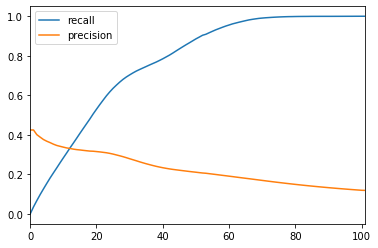

In [33]:
#plotting precision-recall curve
pr = trainingSummary.pr.toPandas()
pr.plot()


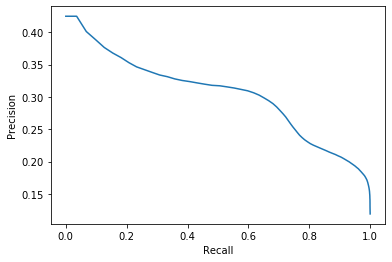

In [34]:
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Gradient Boosted Trees

In [35]:
categories = ['home_ownership', 'term']
stages = []

In [36]:
vectors = VectorAssembler(inputCols = ['loan_amnt', 'home_ownership', 'term',\
                                             'total_pymnt', 'annual_inc', \
                                             'fico_range_low', 'last_pymnt_amnt',\
                                             'int_rate','emp_length_low',\
                                      'grade_EFG', 'grade_CD'], 
                                 outputCol='vector_features')

In [37]:
gbt = GBTClassifier()
stages = [vectors, gbt]

In [38]:
pipeline = Pipeline(stages=stages)

In [39]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 10]) \
    .addGrid(gbt.maxBins, [20, 32, 50])\
    .build()

In [40]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

In [41]:
# Fit the pipeline
model_gbt = crossval.fit(train)

IllegalArgumentException: 'Data type string of column home_ownership is not supported.\nData type string of column term is not supported.'

In [47]:
# Make a prediction
prediction = model.transform(test)
prediction.show(2)

+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+--------------------+----------------------+----------+-------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|grade_CD|grade_EFG|emp_length_low|home_ownership_Index|home_ownershipclassVec|term_Index| termclassVec|     vector_features|     scaled_features|label|            features|       rawPrediction|         probability|prediction|
+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+--------------------+----------------------+----------+-------------+-------------------

In [37]:
!jupyter nbconvert --to pdf '../Spark_ML_DS5559'/*.ipynb

[NbConvertApp] Converting notebook ../Spark_ML_DS5559/Final_Project_DS5559_data.ipynb to pdf
[NbConvertApp] Support files will be in Final_Project_DS5559_data_files/
[NbConvertApp] Making directory ./Final_Project_DS5559_data_files
[NbConvertApp] Writing 80572 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 96996 bytes to ../Spark_ML_DS5559/Final_Project_DS5559_data.pdf
[NbConvertApp] Converting notebook ../Spark_ML_DS5559/Project_Models.ipynb to pdf
[NbConvertApp] Writing 43276 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNIN

## Confusion Matrix

In [43]:
#from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import confusion_matrix

In [55]:
#predictionAndLabels = test.map(lambda lp: (float(model.predict(lp.features)), lp.label))
y_true = prediction.select("loan_status_binary")
y_true = y_true.toPandas()

y_pred = prediction.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0, 1])
cnf_matrix

array([[118878,   1097],
       [ 15324,    783]])

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[118878   1097]
 [ 15324    783]]


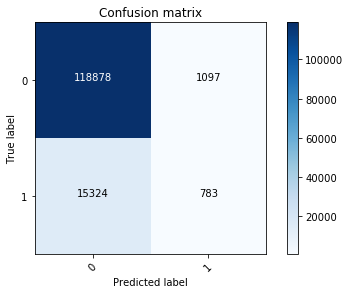

In [57]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix')
plt.show()